In [184]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestNeighbors


In [150]:
train_df = pd.read_csv("option_train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   1680 non-null   float64
 1   S       1680 non-null   float64
 2   K       1680 non-null   int64  
 3   tau     1680 non-null   float64
 4   r       1680 non-null   float64
 5   BS      1680 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 78.9+ KB


## Preprocessing

In [151]:
train_df.head()

,Value,S,K,tau,r,BS
0,21.670404,431.623898,420,0.341270,0.03013,Under
1,0.125000,427.015526,465,0.166667,0.03126,Over
2,20.691244,427.762336,415,0.265873,0.03116,Under
3,1.035002,451.711658,460,0.063492,0.02972,Over
4,39.553020,446.718974,410,0.166667,0.02962,Under


In [152]:
train_df.BS = train_df.BS.replace({'Under':0, 'Over':1})
train_df = train_df.drop(columns = ['Value']) 
# assume we can't use Value so we drop it

X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]

## Creating variables & MinMaxScale

In [153]:
# df = X

# cols = list(X.columns)[:-1]
# for i in cols:
#     for ii in cols:
#         if i != ii:
#             name1 = str(i)+"*"+str(ii)
#             name2 = str(i)+"/"+str(ii)
#             df[name1] = df[i]*df[ii]
#             df[name2] = df[i]/df[ii]

# X.head()

In [154]:
# define function 
# multiplying all fields 

def create_variables(df):
    cols = list(df.columns)[:-1]
    for i in cols:
        cols.remove(i)
        for ii in cols:
            if i != ii:
                name = str(i)+"*"+str(ii)
                # name2 = str(i)+"/"+str(ii)
                df[name] = df[i]*df[ii]
                # df[name2] = df[i]/df[ii]
        for iii in cols:
            #print(f'i:{i}, ii:{ii}, iii:{iii}')
            if i != iii and ii != iii and i != ii:
                #print(f'i:{i}, ii:{ii}, iii:{iii}')
                name = str(i)+"*"+str(ii)+"*"+str(iii)
                df[name] = df[i]*df[ii]*df[iii]

    return df

create_variables(X)

,S,K,tau,r,S*K,S*tau,S*tau*K,tau*K
0,431.623898,420,0.341270,0.03013,181282.037286,147.300219,61866.092041,143.333333
1,427.015526,465,0.166667,0.03126,198562.219543,71.169254,33093.703323,77.500000
2,427.762336,415,0.265873,0.03116,177521.369606,113.730463,47198.141942,110.337302
3,451.711658,460,0.063492,0.02972,207787.362588,28.680105,13192.848316,29.206349
4,446.718974,410,0.166667,0.02962,183154.779504,74.453163,30525.796645,68.333333
...,...,...,...,...,...,...,...,...
1675,444.397163,475,0.273810,0.03034,211088.652662,121.680176,57798.083507,130.059524
1676,438.453825,410,0.301587,0.02972,179766.068250,132.232106,54215.163515,123.650794
1677,428.042219,390,0.170635,0.03188,166936.465410,73.038950,28485.190587,66.547619
1678,439.081203,480,0.293651,0.02962,210758.977248,128.936544,61889.541012,140.952381


In [155]:
cols = X.columns
X = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X, columns = cols )
X.head()

,S,K,tau,r,S*K,S*tau,S*tau*K,tau*K
0,0.202299,0.36,0.867347,0.261603,0.336600,0.829308,0.717168,0.749947
1,0.050749,0.72,0.418367,0.738397,0.604273,0.395640,0.379609,0.401345
2,0.075309,0.32,0.673469,0.696203,0.278347,0.638083,0.545083,0.575226
3,0.862901,0.68,0.153061,0.088608,0.747172,0.153608,0.146132,0.145619
4,0.698712,0.28,0.418367,0.046414,0.365609,0.414346,0.349483,0.352805


In [156]:
X.shape

(1680, 8)

## Feature Selection
- backward wrapper with logistics model 

In [157]:

def backward_wrapper(x, y, estimator):
    '''
    n - number of top variables sorted by grid_score_
    '''
    from sklearn.linear_model import LogisticRegression
    #from sklearn.tree import DecisionTreeClassifier
    from sklearn.feature_selection import RFECV
    
    if estimator == 'logreg':
        model = LogisticRegression(penalty='l2', class_weight='balanced')
    elif estimator == 'dt':
        model = DecisionTreeClassifier()
    
    rfecv = RFECV(estimator=model, step=1, cv=2, verbose=2, n_jobs=1, scoring="roc_auc")
    rfecv.fit(x, y)
    
    print(rfecv.ranking_)


    tops = pd.DataFrame()
    tops['var'] = x.columns;tops['rank'] = rfecv.ranking_
    tops = tops[tops['rank'] == 1]
    # #if estimator == 'dt':
    # tops = tops.sort_values('rank').reset_index(inplace = False)
    # tops = tops.iloc[:n,:]
    
    
    plt.figure()
    plt.xlabel("Number of Feature Selected")
    plt.ylabel("Cross Validation Score")
    plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
    plt.show()
    
    return tops 

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
[1 1 2 1 1 1 3 1]


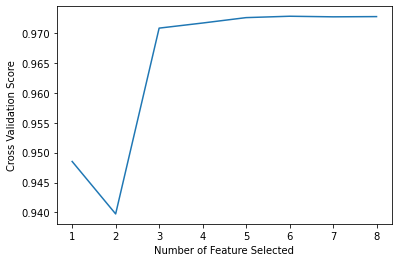

In [158]:
select = backward_wrapper(
    x = X,
    y = y,
    estimator = 'logreg'
)

In [159]:
select

,var,rank
0,S,1
1,K,1
3,r,1
4,S*K,1
5,S*tau,1
7,tau*K,1


In [162]:
# Select top ranking variales as X
X = X.loc[:, list(select['var'])]
X.head()

,S,K,r,S*K,S*tau,tau*K
0,0.202299,0.36,0.261603,0.336600,0.829308,0.749947
1,0.050749,0.72,0.738397,0.604273,0.395640,0.401345
2,0.075309,0.32,0.696203,0.278347,0.638083,0.575226
3,0.862901,0.68,0.088608,0.747172,0.153608,0.145619
4,0.698712,0.28,0.046414,0.365609,0.414346,0.352805


## Model Training
- Log Reg
- LDA
- KNN
- DT

Goodness will be measured by classification error rate *e*:

$$ e = \dfrac{FP+FN}{TP+TN+FP+FP} $$

### Log Reg

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state = 1)

logreg = LogisticRegression().fit(X_train, y_train)
e = 1-logreg.score(X_test, y_test)
e

0.06845238095238093

In [183]:
# Now doing this multiple times 

e_list = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = i)
    logreg = LogisticRegression().fit(X_train, y_train)
    e = 1-logreg.score(X_test, y_test)
    e_list.append(e)

e = sum(e_list)/len(e_list)
e  



0.08244047619047619

In [200]:
# define function

def model_e(X, y, model):
    '''
    model: one of 'logreg', 'lda', 'knn' 
    '''
    if model == 'logreg':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression()
    elif model == 'lda':
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        model = LinearDiscriminantAnalysis()
    elif model == 'knn':
        print("Please choose your n for KNN model:")
        n = int(input()) # n of your choice
        print(f"Choose {n}.")
        from sklearn.neighbors import KNeighborsClassifier
        model = KNeighborsClassifier(n_neighbors=n)

    e_list = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = i)
        model.fit(X_train, y_train)
        e = 1-model.score(X_test, y_test)
        e_list.append(e)

    e = sum(e_list)/len(e_list)
    print(f'Average classification error rate for {model} is {round(e,4)}.')
        

model_e(X, y, 'logreg')




Average classification error rate for LogisticRegression() is 0.0824.


In [179]:

## ??? not sure if we need to do CV
# and i'm not sure if this is the right way to do CV 

scores = cross_val_score(logreg, X_train, y_train, cv=10)
1 - scores.mean()

0.09148700939745713

### LDA

In [191]:
model_e(X, y, 'lda')

Average classification error rate for LinearDiscriminantAnalysis() is 0.0807.


KNN

In [201]:
# when n = 5

model_e(X, y, 'knn')

Please choose your n for KNN model:
Choose 5.
Average classification error rate for KNeighborsClassifier() is 0.0759.


In [202]:
model_e(X, y, 'knn')

Please choose your n for KNN model:
Choose 3.
Average classification error rate for KNeighborsClassifier(n_neighbors=3) is 0.0714.


In [203]:
model_e(X, y, 'knn')

Please choose your n for KNN model:
Choose 2.
Average classification error rate for KNeighborsClassifier(n_neighbors=2) is 0.0857.


In [204]:
model_e(X, y, 'knn')

Please choose your n for KNN model:
Choose 4.
Average classification error rate for KNeighborsClassifier(n_neighbors=4) is 0.0804.


In [205]:
model_e(X, y, 'knn')

Please choose your n for KNN model:
Choose 6.
Average classification error rate for KNeighborsClassifier(n_neighbors=6) is 0.0804.


KNN performs best when n = 3.